# ㅇㅅ

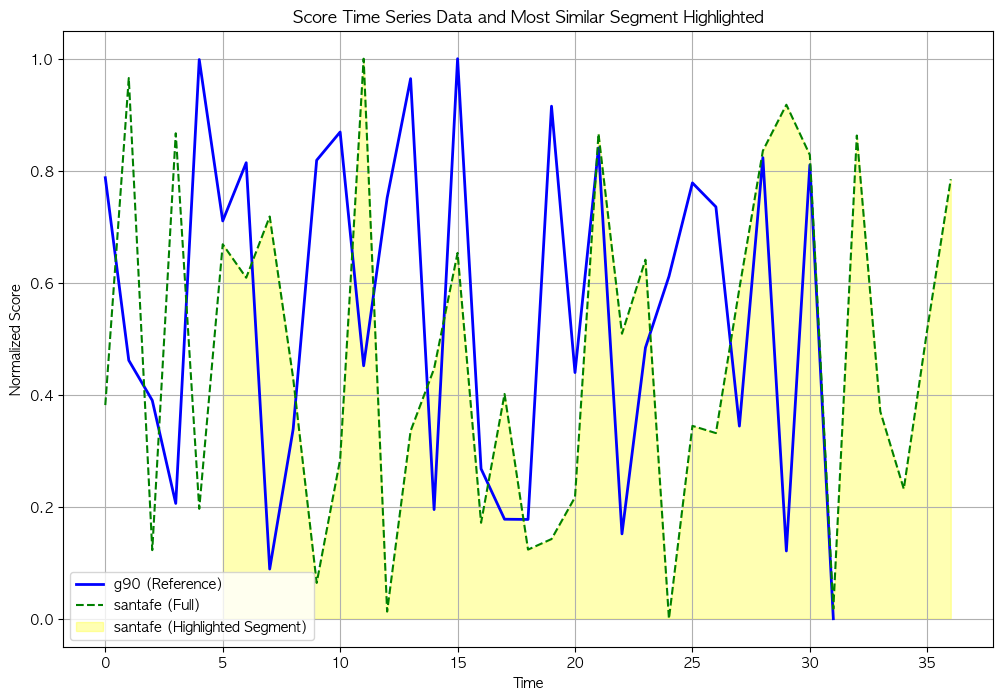

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.preprocessing import MinMaxScaler

# 임의의 데이터프레임 생성 함수
def generate_random_post_data(num_rows, start_date, end_date, car_names, sentiment_range=(1, 10), view_count_range=(100, 1000), post_count_range=(10, 100), comment_count_range=(5, 50)):
    date_range = pd.date_range(start=start_date, end=end_date, periods=num_rows)
    car_name_choices = np.random.choice(car_names, num_rows)
    sentiment_values = np.random.randint(sentiment_range[0], sentiment_range[1], num_rows)
    view_counts = np.random.randint(view_count_range[0], view_count_range[1], num_rows)
    post_counts = np.random.randint(post_count_range[0], post_count_range[1], num_rows)
    comment_counts = np.random.randint(comment_count_range[0], comment_count_range[1], num_rows)
    
    return pd.DataFrame({
        'DateTime': date_range,
        'CarName': car_name_choices,
        'Sentiment': sentiment_values,
        'ViewCount': view_counts,
        'PostCount': post_counts,
        'CommentCount': comment_counts
    })

# 점수 계산 함수 정의
def calculate_score(view_count, post_count, comment_count):
    return (view_count / post_count) + post_count * 10 + comment_count

# 점수 정규화 함수 정의
def normalize_scores(scores):
    min_score = np.min(scores)
    max_score = np.max(scores)
    return (scores - min_score) / (max_score - min_score) if max_score > min_score else np.zeros_like(scores)

# 임의의 데이터프레임 생성
car_names = ['g90', 'g80', 'santa_fe', 'kona', 'santafe']
post_df = generate_random_post_data(num_rows=300, start_date='2023-01-01', end_date='2023-12-31', car_names=car_names)

# Sentiment 필터링 (부정적인 것만 필터링)
negative_df = post_df[post_df['Sentiment'] <= 5]

# g90에 해당하는 데이터가 있는지 확인
g90_data = negative_df[negative_df['CarName'] == 'g90']
if g90_data.empty:
    print("g90에 해당하는 데이터가 없습니다.")
else:
    # g90의 점수 계산 및 정규화
    reference_scores = [calculate_score(vc, pc, cc) 
                       for vc, pc, cc in zip(g90_data['ViewCount'], g90_data['PostCount'], g90_data['CommentCount'])]
    reference_series = normalize_scores(reference_scores)

    # 비교할 차종 데이터 (코나, 싼타페)
    other_car_names = ['kona', 'santafe']
    similarity_results = {}
    similar_segments = {}

    # 각 차종에 대해 유사도 계산
    for car_name in other_car_names:
        car_data = negative_df[negative_df['CarName'] == car_name]
        if car_data.empty:
            continue
        
        target_scores = [calculate_score(vc, pc, cc) 
                         for vc, pc, cc in zip(car_data['ViewCount'], car_data['PostCount'], car_data['CommentCount'])]
        target_series = normalize_scores(target_scores)
        
        min_distance = float('inf')
        best_segment = None
        
        # 모든 가능한 서브시퀀스에서 유사도 계산
        for i in range(len(target_series) - len(reference_series) + 1):
            segment = target_series[i:i + len(reference_series)]
            distance = fastdtw(reference_series, segment, dist=2)[0]
            
            if distance < min_distance:
                min_distance = distance
                best_segment = (i, i + len(reference_series))
        
        similarity_results[car_name] = min_distance
        similar_segments[car_name] = best_segment

    # 유사도가 가장 높은 차종 찾기
    most_similar_car = min(similarity_results, key=similarity_results.get)
    best_segment = similar_segments[most_similar_car]

    if best_segment:
        # 시각화
        plt.figure(figsize=(12, 8))

        # g90 기준 데이터프레임의 정규화된 점수 그래프
        plt.plot(reference_series, label='g90 (Reference)', linewidth=2, color='blue')

        # 가장 유사한 차종의 정규화된 점수 그래프 전체
        target_series = normalize_scores(
            [calculate_score(vc, pc, cc) 
             for vc, pc, cc in zip(negative_df[negative_df['CarName'] == most_similar_car]['ViewCount'], 
                                   negative_df[negative_df['CarName'] == most_similar_car]['PostCount'], 
                                   negative_df[negative_df['CarName'] == most_similar_car]['CommentCount'])]
        )
        plt.plot(target_series, label=f'{most_similar_car} (Full)', linestyle='--', color='green')

        # 유사한 구간에 형광펜 효과 적용
        plt.fill_between(range(best_segment[0], best_segment[1]), 
                         target_series[best_segment[0]:best_segment[1]], 
                         color='yellow', alpha=0.3, label=f'{most_similar_car} (Highlighted Segment)')

        plt.title('Score Time Series Data and Most Similar Segment Highlighted')
        plt.xlabel('Time')
        plt.ylabel('Normalized Score')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"{most_similar_car} 차종에서 유사한 구간을 찾을 수 없습니다.")


5. DTW (Dynamic Time Warping)를 이용한 패턴 유사도 계산 및 시각화

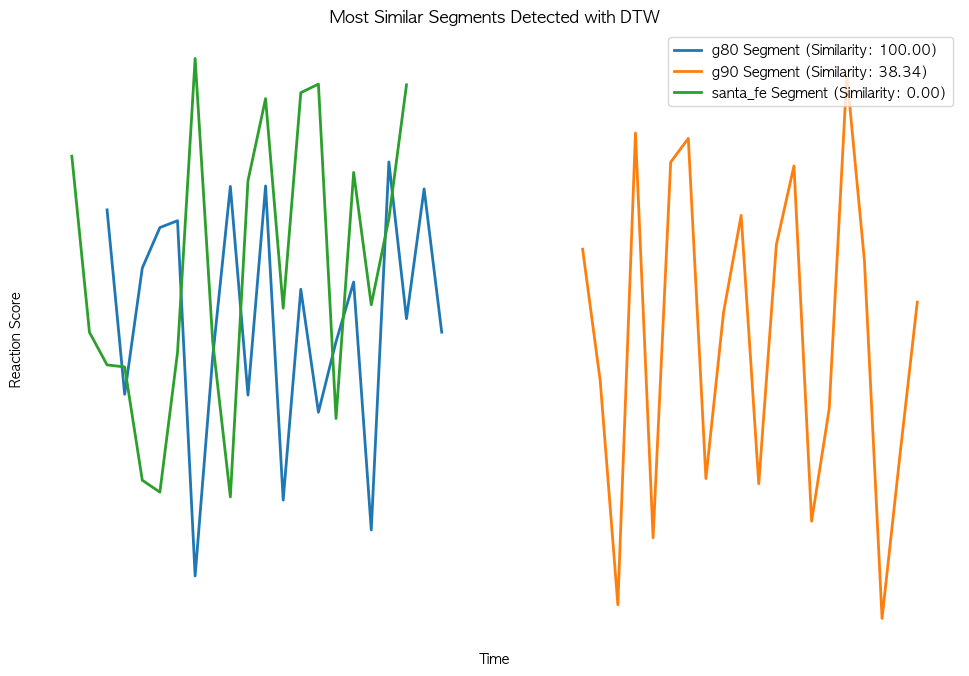

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# 임의의 데이터프레임 생성 함수
def generate_random_post_data(num_rows, start_date, end_date, car_names, sentiment_range=(1, 10), score_range=(0, 100)):
    date_range = pd.date_range(start=start_date, end=end_date, periods=num_rows)
    car_name_choices = np.random.choice(car_names, num_rows)
    sentiment_values = np.random.randint(sentiment_range[0], sentiment_range[1], num_rows)
    scores = np.random.uniform(score_range[0], score_range[1], num_rows)
    
    return pd.DataFrame({
        'DateTime': date_range,
        'CarName': car_name_choices,
        'Sentiment': sentiment_values,
        'Score': scores
    })

# 임의의 데이터프레임 생성
car_names = ['g90', 'g80', 'santa_fe']
post_df = generate_random_post_data(num_rows=300, start_date='2023-01-01', end_date='2023-12-31', car_names=car_names)

# 참고 구간 정의 (예: df1에서 인덱스 20~40)
reference_segment = post_df.iloc[20:40]['Score'].values

# DTW 유사도 계산 함수
def calculate_dtw_similarity(reference_series, target_series):
    distance, _ = fastdtw(reference_series, target_series, dist=2)
    return distance

# 각 데이터프레임에 대해 유사한 구간 찾기
similar_segments = {}
similarity_results = {}
max_possible_distance = float('-inf')
min_possible_distance = float('inf')

# 유사도 계산 및 최댓값, 최솟값 추출
for name, group in post_df.groupby('CarName'):
    target_series = group['Score'].values
    min_distance = float('inf')
    best_segment = None
    
    for i in range(len(target_series) - len(reference_segment) + 1):
        segment = target_series[i:i + len(reference_segment)]
        distance = calculate_dtw_similarity(reference_segment, segment)
        
        if distance < min_distance:
            min_distance = distance
            best_segment = (i, i + len(reference_segment))
    
    similar_segments[name] = best_segment
    similarity_results[name] = min_distance
    
    # 유사도 거리의 최댓값과 최솟값 업데이트
    if min_distance > max_possible_distance:
        max_possible_distance = min_distance
    if min_distance < min_possible_distance:
        min_possible_distance = min_distance

# 거리 값을 0~100 사이의 유사도로 변환
for name in similarity_results:
    normalized_similarity = 100 * (1 - (similarity_results[name] - min_possible_distance) / (max_possible_distance - min_possible_distance))
    similarity_results[name] = normalized_similarity

# 유사한 구간 시각화 (유사도 값을 범례에 포함)
plt.figure(figsize=(12, 8))

for name, segment in similar_segments.items():
    plt.plot(range(segment[0], segment[1]), 
             post_df[post_df['CarName'] == name]['Score'].values[segment[0]:segment[1]], 
             label=f'{name} Segment (Similarity: {similarity_results[name]:.2f})', 
             linewidth=2)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
# 마이너스 기호가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False

# 배경색과 배경선을 제거
ax = plt.gca()
ax.set_facecolor('none')  # 배경색 제거
ax.spines['top'].set_visible(False)  # 상단 경계선 제거
ax.spines['right'].set_visible(False)  # 우측 경계선 제거
ax.spines['left'].set_visible(False)  # 좌측 경계선 제거
ax.spines['bottom'].set_visible(False)  # 하단 경계선 제거
ax.grid(False)  # 배경 그리드 제거
ax.set_xticks([])  # x축 눈금 제거
ax.set_yticks([])  # y축 눈금 제거

plt.title('Most Similar Segments Detected with DTW')
plt.xlabel('Time')
plt.ylabel('Reaction Score')
plt.legend()
plt.show()


가장 유사한 차종: 싼타페, 유사도: 100.00


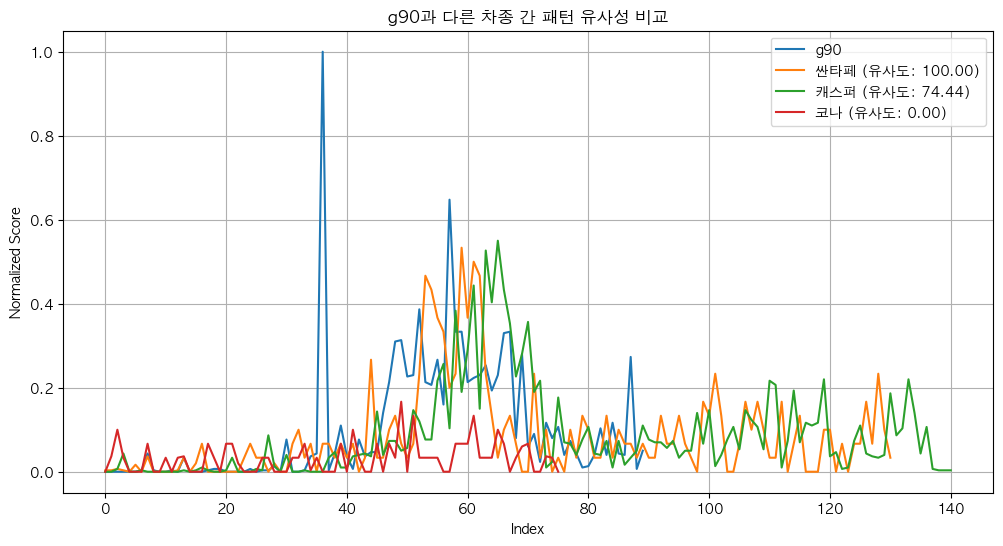

In [35]:
from sklearn.preprocessing import MinMaxScaler
from dtaidistance import dtw
import numpy as np
import matplotlib.pyplot as plt

# Score 정규화
scaler = MinMaxScaler()
merged_df['NormalizedScore'] = scaler.fit_transform(merged_df[['Score']])

# g90의 정규화된 Score 추출
g90_scores = merged_df[merged_df['CarName'] == 'g90']['NormalizedScore'].values

# 각 차종과 g90의 패턴 유사도 계산 및 유사 구간 찾기
similarity_scores = {}
aligned_indices = {}
max_distance = float('-inf')
min_distance = float('inf')

for car in merged_df['CarName'].unique():
    if car != 'g90':
        car_scores = merged_df[merged_df['CarName'] == car]['NormalizedScore'].values
        
        if len(car_scores) == 0 or len(g90_scores) == 0:
            print(f"{car} 또는 g90의 데이터가 부족합니다.")
            continue
        
        # DTW 유사도 계산
        distance, paths = dtw.warping_paths(g90_scores, car_scores)
        similarity_scores[car] = distance
        
        # 유사한 구간의 인덱스 저장
        aligned_indices[car] = paths

        # 최대 및 최소 거리 추적
        max_distance = max(max_distance, distance)
        min_distance = min(min_distance, distance)

# 거리 값을 0~100 사이의 유사도로 변환
for car in similarity_scores:
    normalized_similarity = 100 * (1 - (similarity_scores[car] - min_distance) / (max_distance - min_distance))
    similarity_scores[car] = normalized_similarity

# 가장 유사한 차종 찾기
most_similar_car = max(similarity_scores, key=similarity_scores.get)
most_similar_indices = aligned_indices[most_similar_car]

print(f"가장 유사한 차종: {most_similar_car}, 유사도: {similarity_scores[most_similar_car]:.2f}")

# 유사한 패턴을 시각화
plt.figure(figsize=(12, 6))
plt.plot(g90_scores, label='g90')
for car, similarity in similarity_scores.items():
    plt.plot(merged_df[merged_df['CarName'] == car]['NormalizedScore'].values, label=f'{car} (유사도: {similarity:.2f})')

plt.xlabel('Index')
plt.ylabel('Normalized Score')
plt.title('g90과 다른 차종 간 패턴 유사성 비교')
plt.legend()
plt.grid(True)
plt.show()


각 차종과 g90 기준 구간의 유사도: {'코나': inf, '싼타페': 1232.3125}
가장 유사한 차종: 싼타페, 유사한 구간: (1, 91)


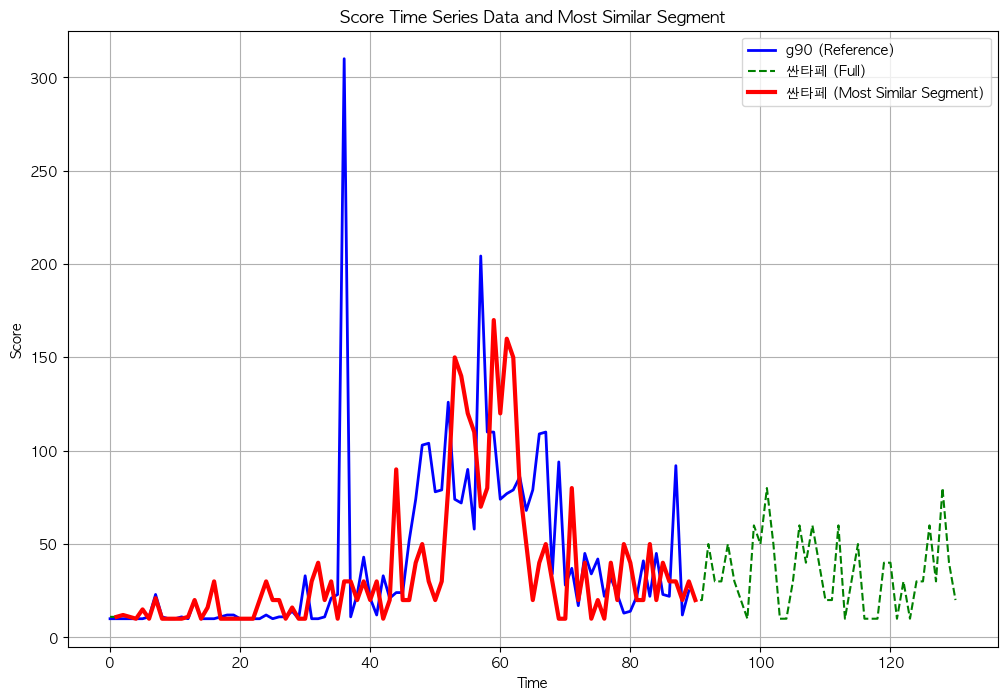

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from sklearn.preprocessing import MinMaxScaler

# 데이터프레임이 이미 존재한다고 가정 (post_df, comment_df)

# g90 기준으로 다른 차종과 비교
g90_df = merged_df[merged_df['CarName'] == 'g90']
reference_viewcount = g90_df['Score'].dropna().values

# 코나와 싼타페 데이터
kona_df = merged_df[merged_df['CarName'] == '코나']
santafe_df = merged_df[merged_df['CarName'] == '싼타페']

# 데이터프레임에서 Score 컬럼을 추출하여 리스트로 저장
view_counts = [kona_df['Score'].dropna().values, santafe_df['Score'].dropna().values]
car_names = ['코나', '싼타페']

# DTW를 이용한 패턴 유사도 계산 함수
def calculate_dtw_similarity(reference_series, target_series):
    if len(reference_series) == 0 or len(target_series) == 0:
        return float('inf')  # 길이가 0인 경우 무한대로 거리 설정
    distance, _ = fastdtw(reference_series, target_series)
    return distance

# 각 데이터프레임의 Score와 기준 구간(g90)과의 유사도 계산
similarity_results = {}
similar_segments = {}

for i, view_count in enumerate(view_counts):
    min_distance = float('inf')
    best_segment = None
    
    # 모든 가능한 서브시퀀스에서 유사도 계산
    for j in range(len(view_count) - len(reference_viewcount) + 1):
        segment = view_count[j:j + len(reference_viewcount)]
        
        # 시계열 길이 확인
        if len(segment) != len(reference_viewcount):
            continue
        
        # 시계열 데이터의 길이와 타입을 확인
        segment = np.asarray(segment)
        distance = calculate_dtw_similarity(reference_viewcount, segment)
        
        if distance < min_distance:
            min_distance = distance
            best_segment = (j, j + len(reference_viewcount))
    
    similarity_results[car_names[i]] = min_distance
    similar_segments[car_names[i]] = best_segment

# 유사도가 가장 높은 데이터프레임 찾기
most_similar_car = min(similarity_results, key=similarity_results.get)
best_segment = similar_segments[most_similar_car]

# 결과 출력
print("각 차종과 g90 기준 구간의 유사도:", similarity_results)
print(f"가장 유사한 차종: {most_similar_car}, 유사한 구간: {best_segment}")

# 시각화
plt.figure(figsize=(12, 8))

# g90 기준 데이터프레임의 Score 그래프
plt.plot(reference_viewcount, label='g90 (Reference)', linewidth=2, color='blue')

# 가장 유사한 차종의 Score 그래프 전체
plt.plot(view_counts[car_names.index(most_similar_car)], label=f'{most_similar_car} (Full)', linestyle='--', color='green')

# 가장 유사한 구간 강조
plt.plot(range(best_segment[0], best_segment[1]), 
         view_counts[car_names.index(most_similar_car)][best_segment[0]:best_segment[1]], 
         label=f'{most_similar_car} (Most Similar Segment)', linewidth=3, color='red')

plt.title('Score Time Series Data and Most Similar Segment')
plt.xlabel('Time')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
import glob
import os
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# 데이터 불러오기 및 전처리
def load_and_preprocess_data(post_path, comment_path):
    post_files = glob.glob(os.path.join(post_path, "*.csv"))
    comment_files = glob.glob(os.path.join(comment_path, "*.csv"))
    
    post_df = pd.concat([pd.read_csv(f) for f in post_files], ignore_index=True)
    comment_df = pd.concat([pd.read_csv(f) for f in comment_files], ignore_index=True)
    
    post_df['ViewCount'] = pd.to_numeric(post_df['ViewCount'], errors='coerce')
    post_df['DateTime'] = pd.to_datetime(post_df['DateTime'], format='mixed')
    comment_df['DateTime'] = pd.to_datetime(comment_df['DateTime'], format='mixed')
    post_df = post_df.sort_values(by='DateTime')
    comment_df = comment_df.sort_values(by='DateTime')
    
    return post_df, comment_df

# 점수 계산
def calculate_scores(post_df, comment_df):
    post_count_df = post_df.groupby(['DateTime', 'CarName']).size().reset_index(name='post_count')
    comment_count_df = comment_df.groupby(['DateTime', 'CarName']).size().reset_index(name='comment_count')
    
    score_df = post_df.groupby(['DateTime', 'CarName']).agg({'ViewCount': 'sum', 'CarName': 'size'}).rename(columns={'CarName': 'post_count'}).reset_index()
    score_df = pd.merge(score_df, comment_count_df, on=['DateTime', 'CarName'], how='left')
    score_df['comment_count'] = score_df['comment_count'].fillna(0)
    score_df['score'] = score_df['ViewCount'] / score_df['post_count'] + score_df['post_count'] * 10 + score_df['comment_count']
    
    sentiment_df = post_df.groupby(['DateTime', 'CarName'])['Sentiment'].mean().reset_index()
    score_df = pd.merge(score_df, sentiment_df, on=['DateTime', 'CarName'], how='left')
    
    return score_df

# Bokeh 시각화 함수
def plot_bokeh_figure(score_df, title, normalized=False):
    p = figure(x_axis_type="datetime", title=title, height=400, width=800)
    
    for car in score_df['CarName'].unique():
        car_data = score_df[score_df['CarName'] == car]
        color = assign_color(car)
        
        if normalized:
            norm_score = (car_data['score'] - car_data['score'].min()) / (car_data['score'].max() - car_data['score'].min())
            p.line(car_data['DateTime'], norm_score, color=color, legend_label=car, line_width=2)
        else:
            p.line(car_data['DateTime'], car_data['score'], color=color, legend_label=car, line_width=2)
    
    hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Score", "@y")], formatters={'@x': 'datetime'}, mode='vline')
    p.add_tools(hover)
    show(p)

# 차종에 따른 색상 지정
def assign_color(car):
    color_map = {
        '코나': 'blue',
        'g90': 'green',
        '싼타페': 'orange',
        '캐스퍼': 'purple'
    }
    return color_map.get(car, 'gray')

# DTW 유사도 비교 및 시각화 함수
def plot_dtw_similarity(weekly_score_df, base_car, compare_cars):
    base_car_score = weekly_score_df[weekly_score_df['CarName'] == base_car]['score'].values
    
    for car in compare_cars:
        car_score = weekly_score_df[weekly_score_df['CarName'] == car]['score'].values
        distance, path = fastdtw(base_car_score, car_score, dist=2)
        
        p = figure(title=f"Weekly DTW Comparison: {base_car} vs {car}", height=400, width=800)
        p.line(list(range(len(base_car_score))), base_car_score, color=assign_color(base_car), legend_label=base_car, line_width=2)
        p.line(list(range(len(car_score))), car_score, color=assign_color(car), legend_label=car, line_width=2)
        
        for (ix, jx) in path:
            p.line([ix, ix], [base_car_score[ix], car_score[jx]], color="gray", line_width=1, alpha=0.5)
        
        show(p)

# 메인 실행 코드
if __name__ == "__main__":
    output_notebook()
    
    post_path = "/Users/admin/softeer/project/0812/post/"
    comment_path = "/Users/admin/softeer/project/0812/comment/"
    
    post_df, comment_df = load_and_preprocess_data(post_path, comment_path)
    score_df = calculate_scores(post_df, comment_df)
    
    plot_bokeh_figure(score_df, "Car Response Score Over Time")
    plot_bokeh_figure(score_df, "Normalized Car Response Score Over Time", normalized=True)
    
    weekly_score_df = score_df.groupby([pd.Grouper(key='DateTime', freq='W'), 'CarName']).mean().reset_index()
    base_car = '캐스퍼'
    compare_cars = ['코나', '싼타페', 'g90']
    
    plot_dtw_similarity(weekly_score_df, base_car, compare_cars)


Loading BokehJS ...